<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;"> 
Estimación de Edad Mediante Visión Artificial
</p>
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;">
Verificación de Edad en Compras de Alcohol
</p>

<hr style="border: .4px solid #000000; width: 70%; margin: 10px auto;">

<p style="color: #000000; font-size: 18px;">
La cadena de supermercados Good Seed está implementando un sistema para garantizar el cumplimiento de las leyes sobre la venta de alcohol. Este sistema utilizará visión artificial para verificar que las personas que compran alcohol sean mayores de edad. El objetivo es desarrollar un modelo capaz de estimar la edad de una persona a partir de fotografías tomadas en las cámaras de seguridad en el área de pago.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Objetivo del Proyecto:</p>
<p style="color: #000000; font-size: 18px;">
El objetivo es entrenar un modelo de visión artificial que estime la edad de las personas con una alta precisión para verificar que no se venda alcohol a menores de edad. El modelo debe alcanzar un nivel de precisión adecuado en las estimaciones de edad para cumplir con los requisitos legales.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Diccionario de Datos:</p>
<p style="color: #000000; font-size: 18px;">
El conjunto de datos contiene fotografías de personas con su edad correspondiente. Cada imagen debe ser procesada por el modelo para estimar la edad de la persona en ella.
</p>

## Inicialización

In [23]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt 
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [24]:
# Load the Data 
labels = pd.read_csv('faces/labels.csv')

In [25]:
# General Info.
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


El DataFrame contiene **7,591 filas** y **2 columnas**:

- **file_name** (`object`): Nombres de archivos de imágenes. 
- **real_age** (`int64`): Edad real asociada a cada archivo.  

Los tipos de datos son correctos. No hay valores nulos. Ahora revisaremos los duplicados.

In [26]:
# Count duplicates
duplicate_count = labels.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


## EDA

In [27]:
# Basic Statistics
labels.describe()

real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

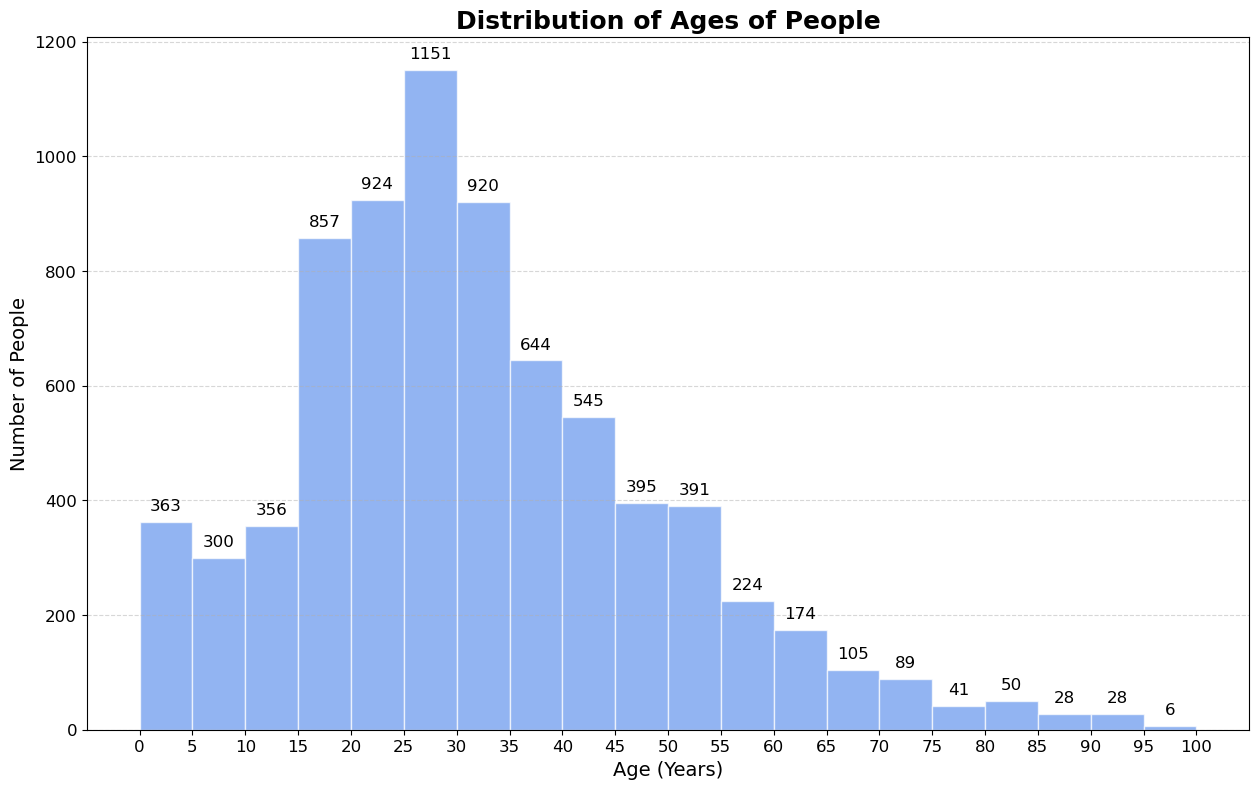

In [28]:
# Create Histogram 
plt.figure(figsize=(15, 9))
# Plot histogram
counts, bins, patches = plt.hist(labels['real_age'], bins=np.arange(0, 105, 5), edgecolor='white', 
                                  linewidth=1, color='cornflowerblue', alpha=0.7)

# Labels and title
plt.title('Distribution of Ages of People', fontsize=18, fontweight='bold')
plt.xlabel('Age (Years)', fontsize=14)
plt.ylabel('Number of People', fontsize=14)
plt.xticks(np.arange(0, 105, 5), fontsize=12)
plt.yticks(fontsize=12)

# Add total count above each bar
for count, x in zip(counts, bins[:-1]):
    plt.text(x + 2.5, count + 20, f'{int(count)}', ha='center', fontsize=12)

# Add gridlines 
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show the plot
plt.show()

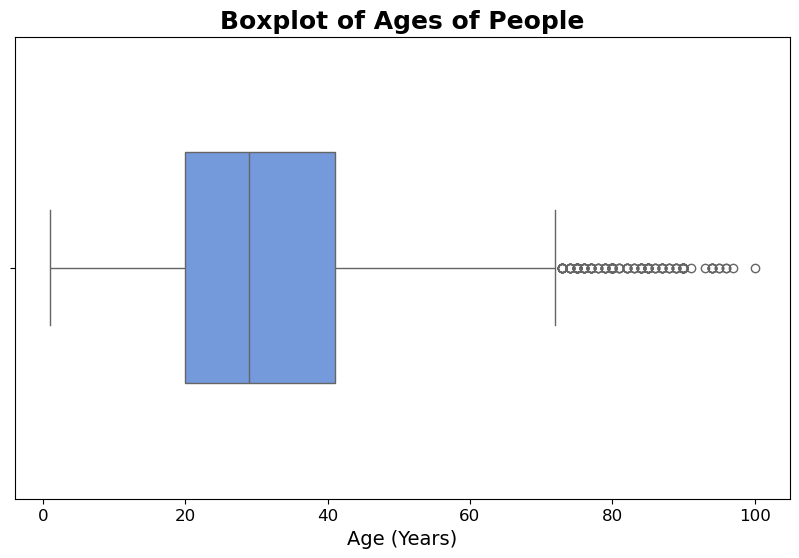

In [29]:
# Boxplot of Ages of People
plt.figure(figsize=(10, 6))
# Create boxplot
sns.boxplot(x=labels['real_age'], color='cornflowerblue', width=0.5)
plt.title('Boxplot of Ages of People', fontsize=18, fontweight='bold')
plt.xlabel('Age (Years)', fontsize=14)
plt.xticks(fontsize=12)
# Show plot
plt.show()

**Análisis de los gráficos**:    
Los datos muestran una distribución con una media de **31.20 años** y una desviación estándar de **17.15 años**, lo que indica una dispersión significativa. La mayoría de las edades se concentran entre los **20.00 y 41.00 años**, según los valores del primer y tercer cuartil, respectivamente. La mediana es de **29.00 años**, lo que sugiere que la mitad de los datos están por debajo de esta edad y la otra mitad por encima. Además, hay valores extremos como **1.00 y 100.00 años**, lo que podría indicar la presencia de outliers o una población diversa en el conjunto de datos.

In [30]:
# Calculate the number of users under the age of 21 and total users
underage = (labels['real_age'] < 21).sum()
all_users = len(labels)

# Print statistics
print(f'There are {underage} people in the dataset out of {all_users} people.')
print(f'This represents {underage / all_users:.2%} of the dataset.')

There are 2054 people in the dataset out of 7591 people.
This represents 27.06% of the dataset.


Podemos ver que más de un cuarto del total de los datos está por debajo de la edad mínima de consumo de alcohol.

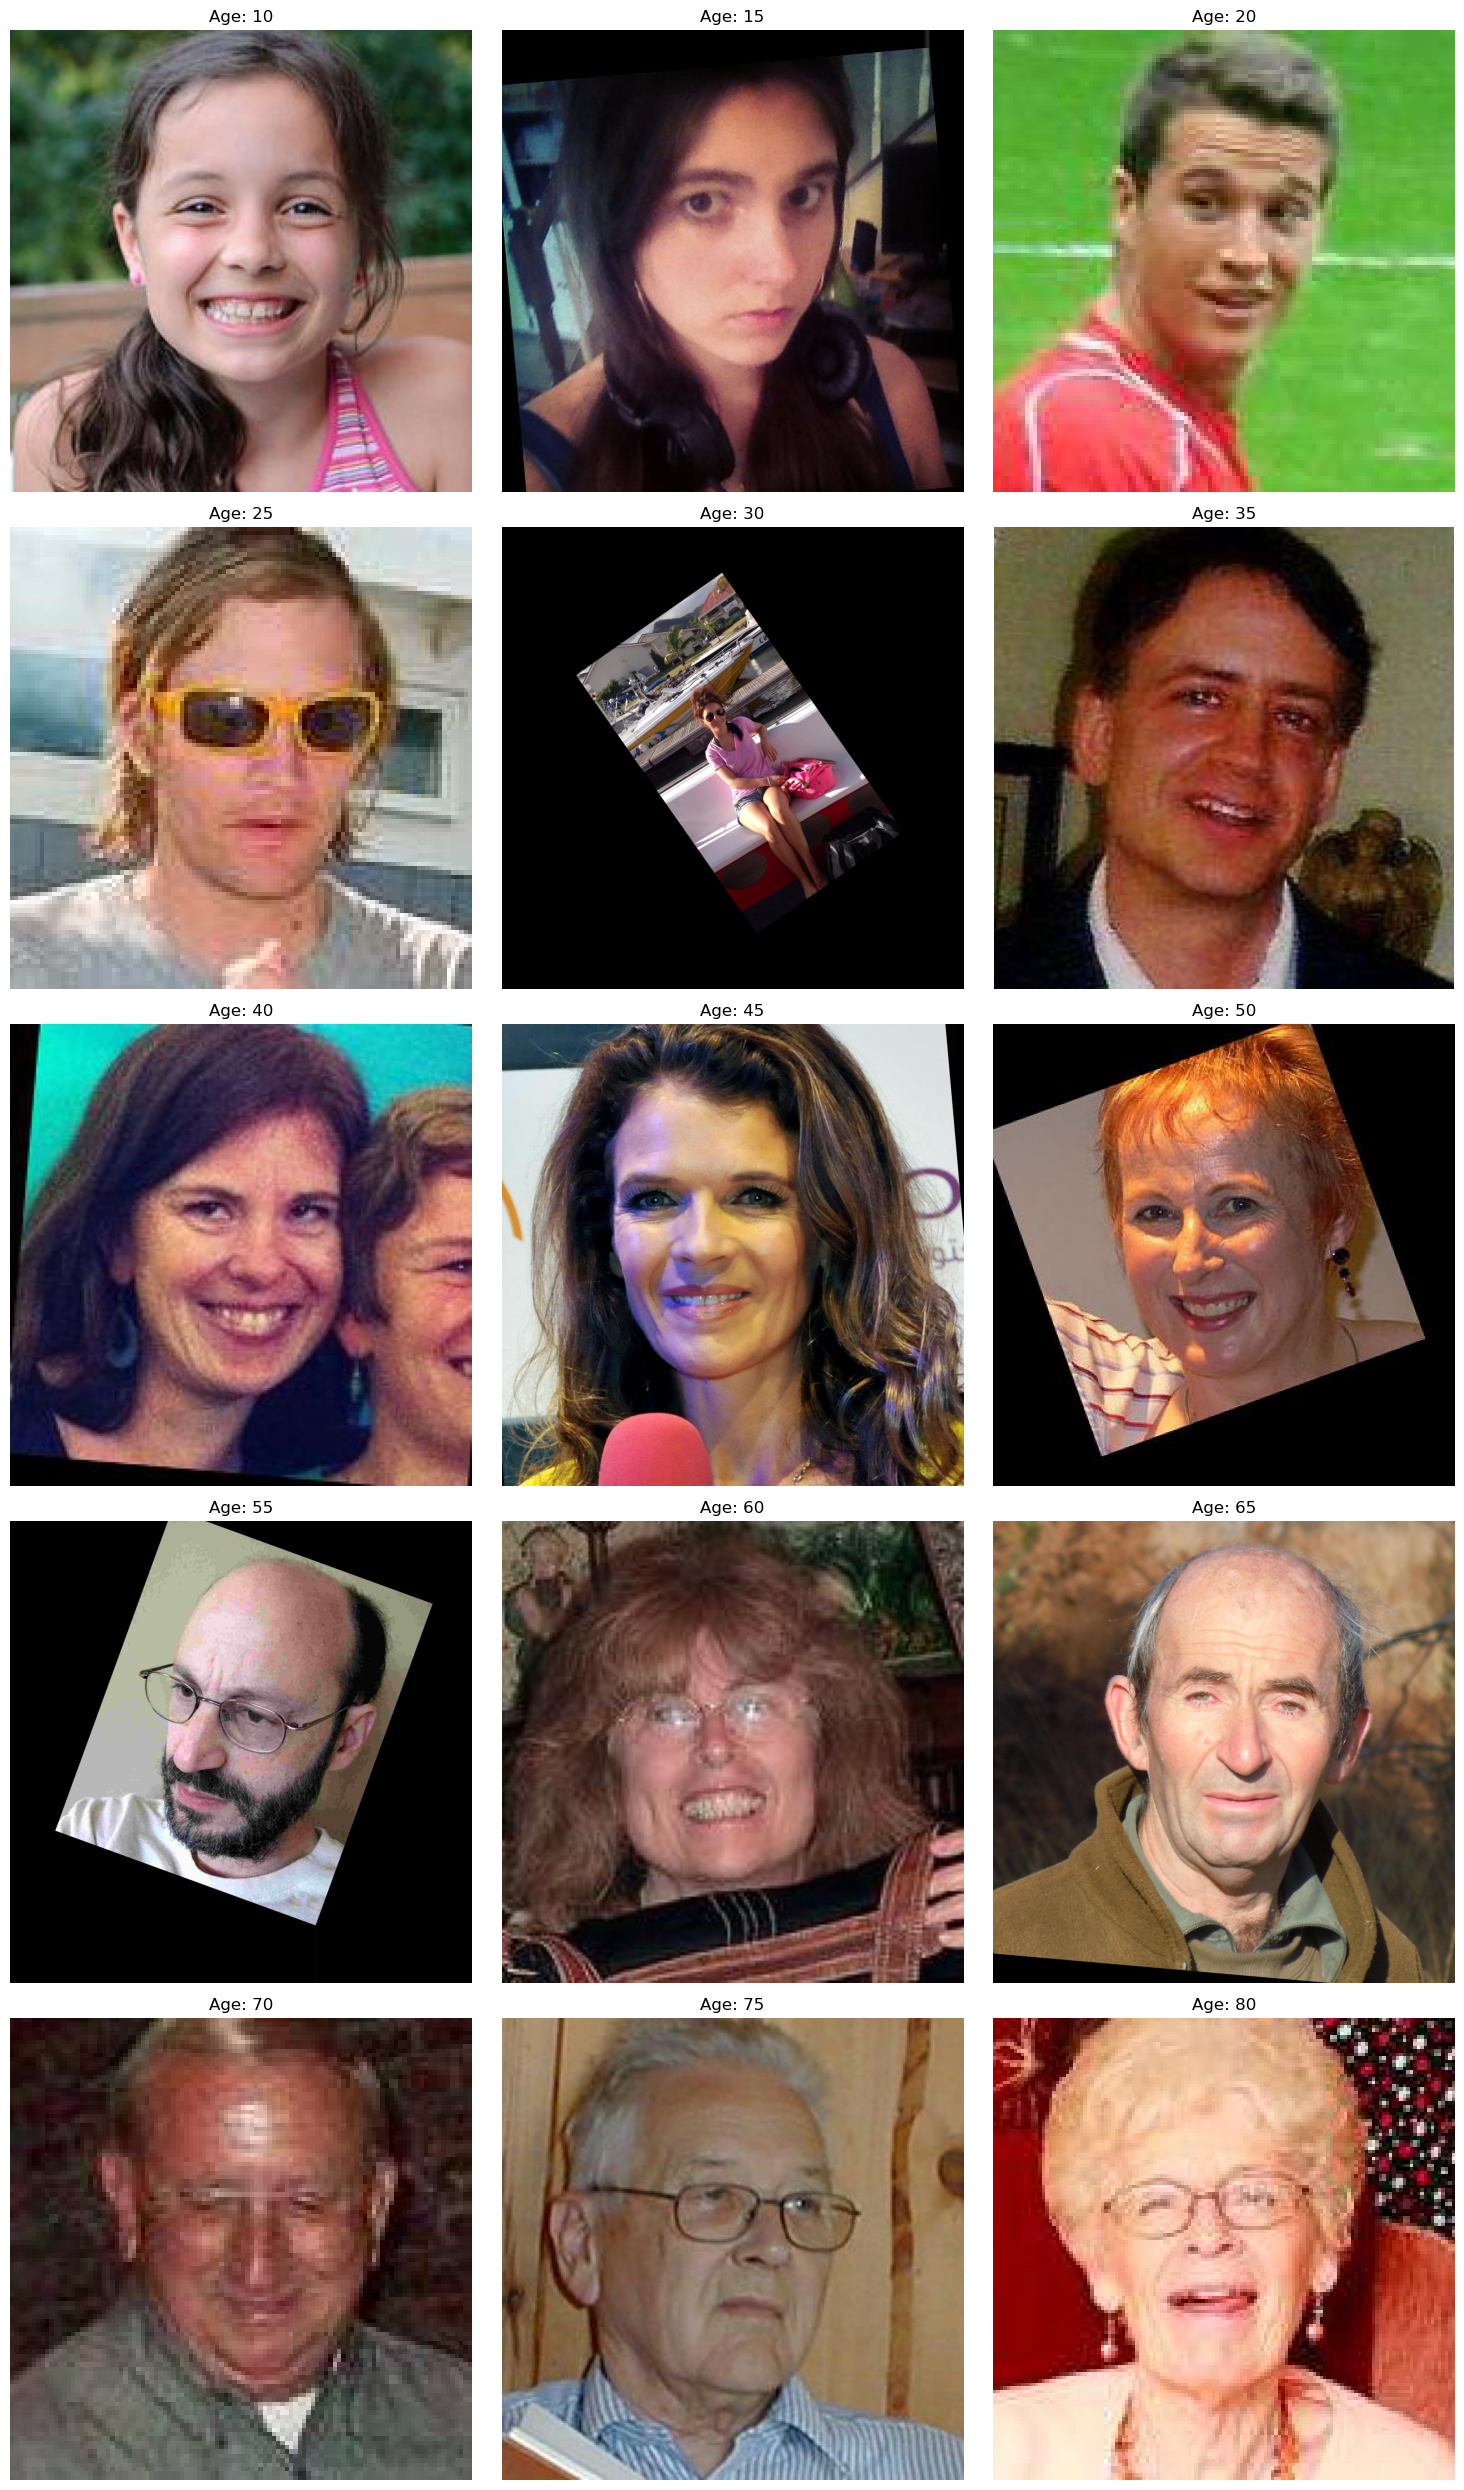

In [31]:
# Create a figure with a grid of subplots (5 rows, 3 columns)
fig, axes = plt.subplots(5, 3, figsize=(15, 5 * 5))
axes = axes.flatten()  # Flatten the 2D array of axes to a 1D array for easier iteration

# Loop through specific ages to display corresponding images
for i, age in enumerate([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]):
    
    # Get the file name of the image corresponding to the selected age
    file_name = labels[labels['real_age'] == age]['file_name'].values[0]
    
    # Construct the full path to the image file
    photo_path = os.path.join('faces/', "final_files", file_name)
    
    # Load the image
    photo = load_img(photo_path)

    # Display the image in the corresponding subplot
    axes[i].imshow(photo)
    axes[i].set_title(f"Age: {age}")  # Set the title indicating the age
    axes[i].axis("off")  # Remove axis ticks and labels for better visualization
    
# Adjust layout to prevent overlapping
plt.tight_layout()
# Show the final figure with all images
plt.show()

### Conclusiones

De las 15 fotos, las de edad 10 y 80, son las unicas con una buena calidad. Las demás estas borrosas, con las caras cortadas, con fondo negro en la foto, incluso una de cuerpo completo con lentes donde se ve minimo la cara. **En general son fotos de mala calidad**.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [39]:
def load_train(path):
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1/255,
        rotation_range=30,
        validation_split=0.25,
        zoom_range=0.2
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        batch_size=16,
        class_mode='raw',
        dataframe=faces_labels,
        directory='/datasets/faces/final_files/',
        seed=12345,
        subset='training',
        target_size=(150, 150),
        x_col='file_name',
        y_col='real_age'
    )
    
    return train_datagen_flow

In [43]:
def load_test(path):
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta.
    """
    test_datagen = ImageDataGenerator(
        rescale=1/255,
        validation_split=0.25
    )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        batch_size=32,
        class_mode='raw',
        dataframe=faces_labels,
        directory='/datasets/faces/final_files/',
        seed=12345,
        subset='validation',
        target_size=(150, 150),
        x_col='file_name',
        y_col='real_age'
    )
    
    return test_datagen_flow

In [44]:

def create_model(input_shape):
    """
    Define the model using ResNet50 as a backbone for regression.
    """
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    backbone.trainable = False  # Optional: freeze the pretrained layers

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))  # or 'relu' if output must be >= 0

    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['mae']
    )
    
    return model

In [47]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Entrena el modelo con los datos de entrenamiento y validación proporcionados.

    Parámetros:
    - model: modelo Keras compilado.
    - train_data: generador o dataset de entrenamiento.
    - test_data: generador o dataset de validación.
    - batch_size: tamaño del batch (solo relevante si no se usa un generador).
    - epochs: número de épocas de entrenamiento.
    - steps_per_epoch: pasos por época (opcional).
    - validation_steps: pasos de validación por época (opcional).

    Retorna:
    - El modelo entrenado.
    """

    # Definir pasos por época si no se especifican
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    # Entrenamiento del modelo
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [46]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Perfecto, has escrito el archivo .py integrando cada una de las funciones par el entrenamiento del modelo.

</div>

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

Resultado de la plataforma GPU:

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps

Epoch 1/20
178/178 - 65s - loss: 245.0955 - mae: 11.1823 - val_loss: 894.1795 - val_mae: 25.0574

Epoch 2/20
178/178 - 38s - loss: 62.5884 - mae: 6.0004 - val_loss: 947.6217 - val_mae: 25.9671

Epoch 3/20
178/178 - 38s - loss: 31.7947 - mae: 4.2828 - val_loss: 331.6021 - val_mae: 13.3702

Epoch 4/20
178/178 - 38s - loss: 19.6925 - mae: 3.4174 - val_loss: 109.8431 - val_mae: 8.0275

Epoch 5/20
178/178 - 38s - loss: 14.7646 - mae: 2.9938 - val_loss: 86.0103 - val_mae: 6.9398

Epoch 6/20
178/178 - 38s - loss: 12.7118 - mae: 2.7601 - val_loss: 70.8739 - val_mae: 6.3532

Epoch 7/20
178/178 - 38s - loss: 10.9120 - mae: 2.5098 - val_loss: 71.6178 - val_mae: 6.5183

Epoch 8/20
178/178 - 38s - loss: 8.4091 - mae: 2.2008 - val_loss: 70.8441 - val_mae: 6.4877

Epoch 9/20
178/178 - 38s - loss: 7.1094 - mae: 2.0067 - val_loss: 70.6308 - val_mae: 6.3671

Epoch 10/20
178/178 - 38s - loss: 7.0045 - mae: 1.9915 - val_loss: 65.9421 - val_mae: 6.2099

Epoch 11/20
178/178 - 38s - loss: 6.7090 - mae: 1.9431 - val_loss: 76.8608 - val_mae: 6.6062

Epoch 12/20
178/178 - 38s - loss: 6.5722 - mae: 1.9482 - val_loss: 65.8247 - val_mae: 6.0685

Epoch 13/20
178/178 - 38s - loss: 5.8667 - mae: 1.8191 - val_loss: 66.8528 - val_mae: 6.3149

Epoch 14/20
178/178 - 38s - loss: 5.2492 - mae: 1.7317 - val_loss: 68.5052 - val_mae: 6.1672

Epoch 15/20
178/178 - 38s - loss: 5.3717 - mae: 1.7398 - val_loss: 64.1595 - val_mae: 6.0654

Epoch 16/20
178/178 - 38s - loss: 5.4877 - mae: 1.7399 - val_loss: 74.2116 - val_mae: 6.4131

Epoch 17/20
178/178 - 39s - loss: 5.2340 - mae: 1.7160 - val_loss: 75.5454 - val_mae: 6.7340

Epoch 18/20
178/178 - 38s - loss: 5.5712 - mae: 1.7661 - val_loss: 64.6718 - val_mae: 6.0515

Epoch 19/20
178/178 - 38s - loss: 5.9201 - mae: 1.8039 - val_loss: 65.5080 - val_mae: 6.1561

Epoch 20/20
178/178 - 38s - loss: 5.5354 - mae: 1.7689 - val_loss: 68.3448 - val_mae: 6.1393

60/60 - 9s - loss: 68.3448 - mae: 6.1393

Test MAE: 6.1393

La puntuación MAE del modelo está dentro del rango esperado.

## Conclusiones

**Mejora del Modelo durante el Entrenamiento**

El modelo ha mostrado una **mejora notable** durante el entrenamiento, reduciendo tanto la **pérdida** como el **MAE** de manera considerable.

- **Al principio**, el MAE era de **11.18**.
- **Al final del entrenamiento**, el MAE alcanzó **1.77** en los datos de entrenamiento y **6.14** en los datos de validación.

Sin embargo, **existe una pequeña brecha** entre el MAE en entrenamiento y validación, lo que sugiere un **posible sobreajuste** del modelo.


**Consideraciones sobre la Distribución de Datos**

Un factor clave a considerar es la distribución de las imágenes:

- **La mayoría de las imágenes** corresponden a personas de **29 a 31 años**.
- Solo un **25%** de las imágenes son de personas **menores de 20 años**, que es el grupo de interés para el análisis de consumo de alcohol.

A pesar de esta limitación en los datos, se logró un **MAE de 6.13 en validación**.

**Sugerencias para Mejorar el Modelo**

Para reducir aún más el **error** y mejorar la generalización, sería ideal contar con **más imágenes de personas menores de edad**. Esto permitiría al modelo **aprender mejor las características de este grupo específico**.

